<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.2 MB/s eta 0:00:00


In [2]:
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load nursing notes subject-caregiver-chartdate

In [12]:

import pandas as pd
import numpy as np
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65708 entries, 0 to 65707
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      65708 non-null  int64 
 1   SUBJECT_ID  65708 non-null  int64 
 2   CGID        65708 non-null  int64 
 3   CHARTDATE   65708 non-null  object
 4   TEXT        65708 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.5+ MB


## Data exploration 

number of notes: min=1, max=31, mean=1.5725636607313804


<Axes: xlabel='TEXT'>

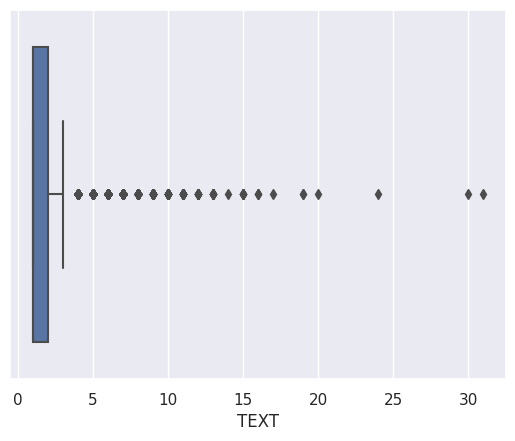

In [28]:
import seaborn as sns
sns.set()

gb_notes = df_notes.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()
print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()}')
sns.boxplot(x=num_notes)

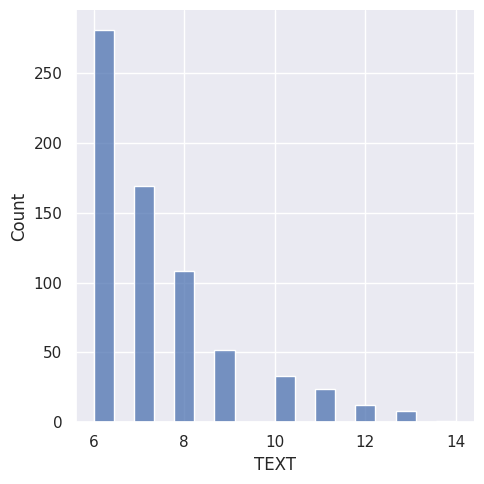

In [44]:
sns.displot(num_notes[((num_notes>5) & (num_notes<15))])
 

## Embeddings 

In [ ]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
  model_output = model(**encoded_input)

for k,v in encoded_input.items():
  print(k)
  print(v.numpy())

input_ids
[[  101  4700  1061 ...     0     0     0]
 [  101  2023  2003 ...  3718  1059   102]
 [  101  2861 10930 ...  2000  8430   102]
 ...
 [  101  5187  1061 ...  1011  5018   102]
 [  101  2720  1012 ...     0     0     0]
 [  101  5388  2546 ...  1008  1008   102]]
token_type_ids
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
attention_mask
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 1 1 1]]


In [ ]:
token_embeddings = model_output.last_hidden_state
print(token_embeddings.size())
print('num of sentences, num of tokens, embed dim')
print('ONE EMBEDDING VECTOR PER TOKEN')

torch.Size([202, 512, 384])
num of sentences, num of tokens, embed dim
ONE EMBEDDING VECTOR PER TOKEN


In [ ]:
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output.last_hidden_state
  input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
  return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)
print('ONE EMBEDDING VECTOR PER SENTENCE')

Sentence embeddings:
tensor([[-0.0450, -0.0408,  0.0401,  ..., -0.0268,  0.0031, -0.0270],
        [-0.0188,  0.0095, -0.0139,  ..., -0.0397,  0.0347,  0.0718],
        [-0.0230, -0.0206, -0.0222,  ..., -0.0719,  0.0716, -0.0368],
        ...,
        [-0.0328,  0.0021, -0.0175,  ..., -0.0331, -0.0105, -0.0132],
        [-0.0227, -0.0065,  0.0247,  ..., -0.0686,  0.0142, -0.0196],
        [-0.0021, -0.0212, -0.0115,  ..., -0.0255,  0.0196, -0.0147]])
ONE EMBEDDING VECTOR PER SENTENCE


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sentence_embeddings_np = sentence_embeddings.detach().numpy()

scores = np.zeros((sentence_embeddings_np.shape[0],sentence_embeddings_np.shape[0]))
dist = []
for idx in range(sentence_embeddings_np.shape[0]):
  scores[idx,:] = cosine_similarity([sentence_embeddings_np[idx]],sentence_embeddings_np)[0]            
  if idx < len(sentence_embeddings_np)-1:
    dist.append(scores[idx,idx+1])

scores     

array([[1.        , 0.39844483, 0.6181047 , ..., 0.64212191, 0.61692476,
        0.63839036],
       [0.39844483, 1.00000024, 0.46432194, ..., 0.43172589, 0.48976815,
        0.43978009],
       [0.6181047 , 0.46432194, 1.        , ..., 0.7098881 , 0.47162813,
        0.57140279],
       ...,
       [0.64212191, 0.43172589, 0.7098881 , ..., 1.00000012, 0.56964445,
        0.65199769],
       [0.61692476, 0.48976815, 0.47162813, ..., 0.56964445, 1.        ,
        0.5653671 ],
       [0.63839036, 0.43978009, 0.57140279, ..., 0.65199769, 0.5653671 ,
        1.00000012]])

<Axes: >

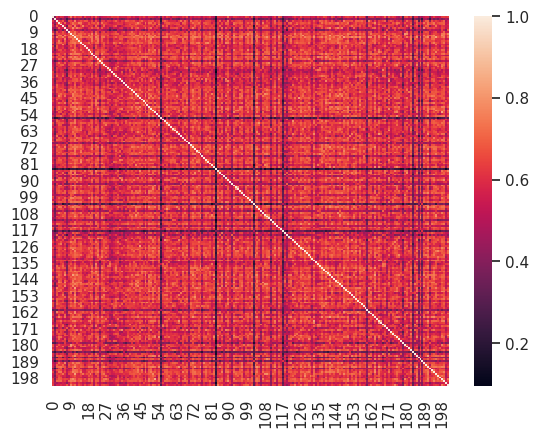

In [ ]:
import seaborn as sns
sns.set()

sns.heatmap(scores)

<Axes: >

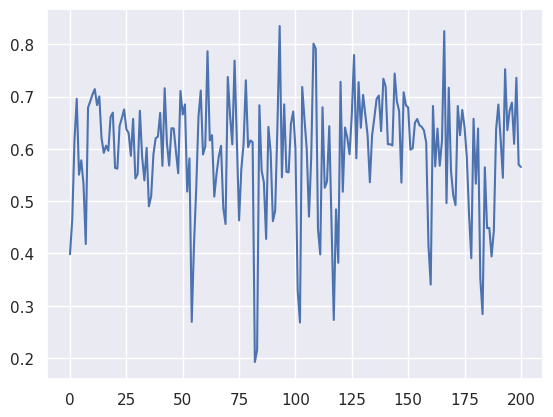

In [ ]:
sns.lineplot(dist)

## Clustering 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
clustering_model = KMeans(n_clusters=6)
clustering_model.fit(sentence_embeddings_np)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[0 0 4 3 2 4 3 5 1 0 3 1 3 3 3 1 1 1 2 2 0 3 0 3 5 3 2 2 4 4 4 4 4 0 3 3 1
 4 2 4 1 0 1 3 1 4 0 3 0 2 3 2 2 1 2 1 4 2 2 2 1 3 3 3 2 4 3 2 2 5 4 3 2 0
 1 2 0 0 3 0 1 1 2 5 0 2 3 1 3 2 3 4 3 2 2 1 2 0 0 3 0 0 5 2 3 2 4 3 1 1 1
 3 2 2 5 0 0 5 5 4 5 3 2 0 3 1 2 3 2 0 2 2 5 2 2 4 4 0 0 2 3 3 2 3 3 3 1 3
 2 2 2 1 2 1 2 4 0 4 0 2 1 2 0 3 3 0 2 2 4 4 5 3 1 0 0 2 3 4 3 0 1 0 0 1 4
 2 5 1 5 3 2 2 5 3 3 1 2 2 2 2 0 0]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentences[sentence_id])
clustered_sentences

{0: ['47 yr old woman admitted through EW w/vaginal bleeding & abdominal pain\n   from fibroids.  On 12R received transfusion X10min, developed crushing\n   chest pain & BP up to 260/110.  Received 10mg IV lopressor & BP down to\n   157/86 w/HR 88 SR no ectopy upon arrival to MICU @ 0500. BP L\n   arm:157/86,  BP R arm: 157/68.  Patient teary eyed & anxious.   C/o\n   nausea, received 4mg IV zofran w/relief.   Sent for head CT w/out\n   contrast which was negative.\n   When patient arrived back from head CT@ 0600, MD discovered that she\n   had new L sided weakness. Unable to lift L arm above head.  Unable to\n   dorsiflex w/ L foot (can do so w/R foot).  Barely able to lift L leg\n   off bed. Could lift R leg high off bed.  Unable to wiggle toes L foot.\n   Can wiggle toes on R.  Patient scheduled for MRI of body.  Patient\n   received 4mg IV morphine @ 0600 for abdominal pain, w/some relief (had\n   [**9-19**] pain which dropped to 5/10).  Said abdominal pain has slowly\n   increased

In [ ]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
X = sentence_embeddings_np 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'cosine'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

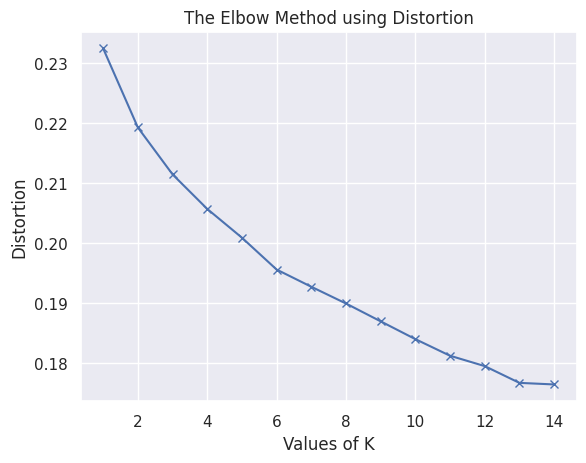

In [ ]:
import matplotlib.pyplot as plt
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()